# Dynamic Linear Model

In [6]:
import os
import math

import torch
import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoNormal
from pyro.optim import Adam
from pyro.infer import SVI, Trace_ELBO, config_enumerate
from pyro.contrib.tracking.extended_kalman_filter import EKFState
from pyro.contrib.tracking.distributions import EKFDistribution
from pyro.contrib.tracking.dynamic_models import NcvContinuous
from pyro.contrib.tracking.measurements import PositionMeasurement
import pyro.poutine as poutine
from pyro.contrib.forecast import ForecastingModel, Forecaster, eval_crps
from pyro.infer.reparam import LocScaleReparam, AutoReparam
from pyro.ops.stats import quantile

from main import get_energy_data, get_weather_data
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler

from tqdm import tqdm

pyro.set_rng_seed(20200928)
torch.manual_seed(20200101)

pd.set_option('display.max_rows', 500)



In [7]:
list(dfW.columns)

NameError: name 'dfW' is not defined

## Data

In [8]:
T = None # number of time steps to include, if None all data is used
test_frac = 0.1 # fraction of data to use for testing

# read data
df = pd.read_csv("preprocessed_data/df.csv")#.iloc[:1000]
df["time_str"] = [d.split("+")[0] for d in df["time_str"]]
df["time_str"] = pd.to_datetime(df["time_str"], infer_datetime_format=True)#'%Y-%m-%d %H:%M:%S.%f') # 2015-01-01 10:00:00+00:00
df = df.groupby("time_str").mean()
df = df.reset_index().set_index('time_str')
df.index.name = None
df = df.asfreq("D") # aggregate data, can be commented out to use all data
dfW = get_weather_data(df)
dfE = get_energy_data(df)


# start, train end, test end
n = len(df) if T is None else T
T0 = 0
T1 = n - int(test_frac*n) # 10 % test data
T2 = n
print("Number of observations:", n)
print("Number of training observations:", T1 - T0)
print("Number of test observations:", T2 - T1)

# convert to torch tensors
# X_W = torch.from_numpy(dfW.values).float()
# X_E = torch.from_numpy(dfE.values).float()
# obs = torch.from_numpy(df["price actual"].values).float()

# standardize data
df_standardized = dfE.merge(dfW, left_index=True, right_index=True)
df_standardized["price_ actual"] = df["price actual"]
scaler = StandardScaler().fit(df_standardized[:T1])
df_standardized = scaler.transform(df_standardized)
df_standardized = pd.DataFrame(df_standardized, columns=list(dfW.columns) + list(dfE.columns) + ["price_actual"], index = df.index)
# print(df_standardized.columns)

# create tensors
X_W = torch.from_numpy(df_standardized[dfW.columns].values).float()
X_E = torch.from_numpy(df_standardized[dfE.columns].values).float()
obs = torch.from_numpy(df_standardized["price_actual"].values).float()

# translate to pyro forecasting language
y = obs.unsqueeze(-1) if T is None else obs[-T:].unsqueeze(-1)
covariates = torch.hstack((X_E, X_W)) if T is None else torch.hstack((X_E, X_W))[-T:]
# covariates = X_E if T is None else X_E[-T:]

# define constants
n, p = covariates.shape
dates = df.index[-n:] # used for plotting



# covariates[:T1].mean(axis = 0), covariates.std(axis = 0)


Number of observations: 1461
Number of training observations: 1315
Number of test observations: 146


## Model

In [68]:
class AR_DLM(ForecastingModel):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.tau = 1
        self.M = 4
        # self.h_dim = X_E.shape[1]
        self.h_dim = 20
        self.gamma = 1
        self.lambda_f = 1

    def model(self, zero_data, X):
        #x_E = X[:, :X_E.shape[1]]
        #x_W = X[:, -X_W.shape[1]:]

        duration, data_dim = zero_data.size()
        feature_dim = covariates.size(-1)

        #theta_f = pyro.sample("theta_f", dist.Normal(0, self.lambda_f).expand((feature_dim, self.h_dim)).to_event(2))
        #theta_g = pyro.sample("theta_g", dist.Normal(0, 1).expand(self.h_dim).to_event(1))
        alpha = pyro.sample("alpha", dist.Normal(0, 0.01).expand([feature_dim]).to_event(1))
        beta = pyro.sample("beta", dist.Normal(0, 0.01).expand([1]).to_event(1))
        gamma = pyro.sample("gamma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))

        ys = []
        y = pyro.sample("y_0", dist.Normal(0, 1).expand([1]).to_event(1))
        ys.append(y)

        #y_plate = pyro.plate("y")
        for t in pyro.markov(range(duration)):
            y_mean = ys[t] + alpha @ X[t].unsqueeze(-1) + beta
            y = pyro.sample(f"y_{t+1}", dist.Normal(y_mean, torch.ones_like(y_mean) * gamma).to_event(1))
            ys.append(y)

        ys = torch.stack(ys, dim=0)[1:]
        pyro.deterministic("prediction", ys)
        #ys = ys.unsqueeze(-1)

        
        sigma = pyro.sample("sigma", dist.HalfCauchy(self.tau).expand([1]).to_event(1))

        noise_dist = dist.Normal(0, sigma)

        self.predict(noise_dist, ys)

pyro.set_rng_seed(1)
pyro.clear_param_store()
model = AR_DLM()
guide = AutoNormal(model)
# optim = Adam({ 'lr': 1e-3 })
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=300,
    guide = guide,
    log_every=10
    # optim = optim,
)

INFO 	 step    0 loss = 4.17897
INFO 	 step   10 loss = 3.2893
INFO 	 step   20 loss = 2.46566
INFO 	 step   30 loss = 1.90706
INFO 	 step   40 loss = 1.43182
INFO 	 step   50 loss = 1.55767
INFO 	 step   60 loss = 1.35576
INFO 	 step   70 loss = 1.25878
INFO 	 step   80 loss = 1.18182
INFO 	 step   90 loss = 1.10945
INFO 	 step  100 loss = 1.14344
INFO 	 step  110 loss = 1.11964
INFO 	 step  120 loss = 1.10632
INFO 	 step  130 loss = 1.05731
INFO 	 step  140 loss = 1.07916
INFO 	 step  150 loss = 1.06144
INFO 	 step  160 loss = 1.06383
INFO 	 step  170 loss = 1.0317
INFO 	 step  180 loss = 1.03023
INFO 	 step  190 loss = 1.05793
INFO 	 step  200 loss = 1.02964
INFO 	 step  210 loss = 1.02441
INFO 	 step  220 loss = 1.01533
INFO 	 step  230 loss = 1.04269
INFO 	 step  240 loss = 1.01611
INFO 	 step  250 loss = 1.02706
INFO 	 step  260 loss = 0.99566
INFO 	 step  270 loss = 1.00842
INFO 	 step  280 loss = 1.00773
INFO 	 step  290 loss = 1.02351


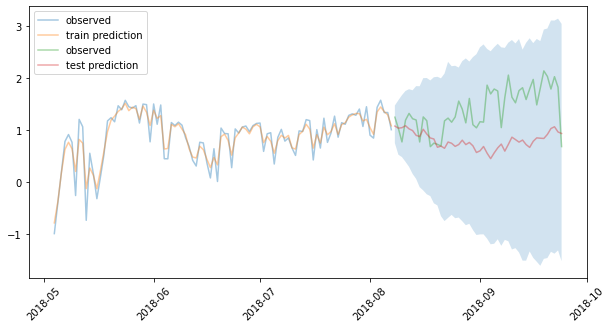

Mean price:  tensor(0.1096)
Mean abs residual:  tensor(0.5724)
Mean abs train residual:  tensor(0.2521)
Mean abs test residual:  tensor(3.4576)


In [70]:

with poutine.trace() as tr:
    forecaster(y[:T1], covariates, num_samples=500)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

#print("posterior shape", .shape)
pred = posterior_samples["prediction"].squeeze().T

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

T_START = T1 - 96
T_END = T1 + 48
ax.plot(dates[T_START:T1], y[T_START:T1], label="observed", alpha= .4)
pred_p10, pred_p50, pred_p90 = quantile(pred, (0.25, 0.5, 0.75)).squeeze(-1)

ax.plot(dates[T_START:T1], pred_p50[T_START:T1], label="train prediction", alpha = .4)

ax.fill_between(dates[T1:T_END], pred_p10[T1:T_END], pred_p90[T1:T_END], alpha = .2)
ax.plot(dates[T1:T_END], y[T1:T_END], label="observed", alpha= .4)
ax.plot(dates[T1:T_END], pred_p50[T1:T_END], label="test prediction", alpha = .4)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation = 45)

plt.show()

resid = obs - pred
print("Mean price: ", obs.mean())
print("Mean abs residual: ", resid.abs().mean())
print("Mean abs train residual: ", resid[:, :T1].abs().mean())
print("Mean abs test residual: ", resid[:, T1:].abs().mean())

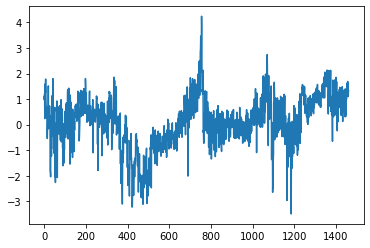

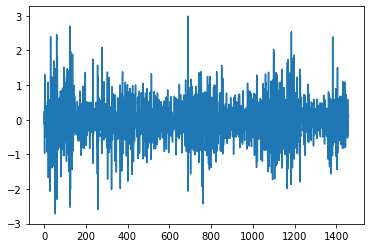

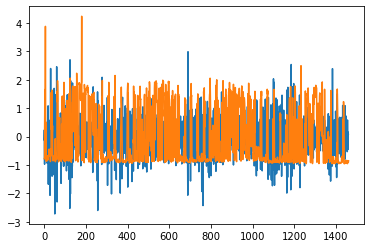

In [126]:
best = posterior_samples["alpha"].flatten(start_dim=1).mean(axis=0).abs().argsort()
#plt.plot(y)

plt.plot(y)
plt.show()

plt.plot(y[1:] - y[:-1])
plt.show()

plt.plot(y[1:] - y[:-1])
plt.plot(covariates[:, best[-1]])
plt.show()

generation waste


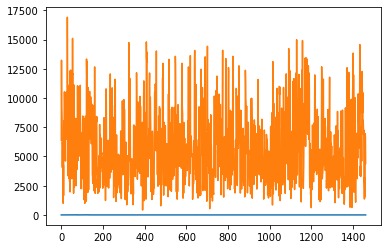

In [82]:
#print(df.columns[8])
#plt.plot(covariates[:, 8])
#plt.plot(df[df.columns[9]].values)
#plt.show()

tensor(8)

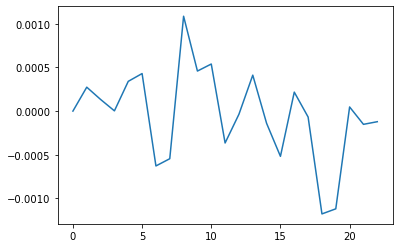

In [29]:
plt.plot(posterior_samples["alpha"].mean(axis = 0).flatten().numpy())
posterior_samples["alpha"].mean(axis = 0).argmax()
# plt.hist(posterior_samples["alpha"][:, :, 0].flatten().numpy(), bins=100)
# plt.hist(posterior_samples["alpha"][:, :, 1].flatten().numpy(), bins=100)
# plt.show()

#plt.hist(posterior_samples["alpha"].flatten().numpy(), bins=100)
#plt.show()

## Inference

In [ ]:
%%time
pyro.set_rng_seed(1)
pyro.clear_param_store()
model = VanillaDLM()
forecaster = Forecaster(
    model,
    y[:T1],
    covariates[:T1],
    learning_rate=0.1,
    learning_rate_decay=0.05,
    num_steps=1000,
)

In [ ]:
pyro.set_rng_seed(1)
# record all latent variables in a trace
with poutine.trace() as tr:
    forecaster(y[:T1], covariates, num_samples=100)

# extract the values from the recorded trace
posterior_samples = {
    name: site["value"]
    for name, site in tr.trace.nodes.items()
    if site["type"] == "sample"
}

# posterior_samples["prediction"].shape


## Analyze posterior samples

In [ ]:
posterior_samples.keys()

In [ ]:
# extract percentiles of the posterior samples
pred_p10, pred_p50, pred_p90 = quantile(posterior_samples['prediction'], (0.1, 0.5, 0.9)).squeeze(-1)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

ax.plot(dates, y, label="observed", alpha= .4)
ax.plot(dates[:T1], pred_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], pred_p50[T1:], label="test prediction", alpha = .4)
ax.legend()

plt.setp(ax.get_xticklabels(), rotation = 45)

plt.show()

In [ ]:
resid = obs - posterior_samples['prediction'].squeeze()

resid_p10, resid_p50, resid_p90 = quantile(resid, (0.1, 0.5, 0.9)).squeeze(-1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# ax.plot(dates, y, label="observed", alpha= .4)
ax.plot(dates[:T1], resid_p50[:T1], label="train prediction", alpha = .4)
ax.plot(dates[T1:], resid_p50[T1:], label="test prediction", alpha = .4)
# ax.fill_between(dates, resid_p10, resid_p90, color="red", alpha=0.3)
ax.legend()
ax.set_title("Residuals, mean abs residual: {:.2f}".format(resid.abs().mean()))

print("Mean price: ", obs.mean())
print("Mean abs residual: ", resid.abs().mean())
print("Mean abs train residual: ", resid[:, :T1].abs().mean())
print("Mean abs residual: ", resid[:, T1:].abs().mean())

In [ ]:
# resid[T1:]
resid.shape